# Banking Customer Segmentation Analysis
# BITS Final Semester Project - Part 1
# This notebook covers: Synthetic Data Creation, Data Preprocessing, and Customer Segmentation


# %% [markdown]
# # Banking Customer Segmentation Analysis
#
# ## Table of Contents
# 1. [Introduction](#introduction)
# 2. [Environment Setup](#setup)
# 3. [Synthetic Data Creation](#synthetic-data)
# 4. [Exploratory Data Analysis](#eda)
# 5. [Data Preprocessing](#preprocessing)
# 6. [Customer Segmentation](#segmentation)
# 7. [Segment Analysis and Profiling](#segment-analysis)
# 8. [Conclusions](#conclusions)

# %% [markdown]
# ## 1. Introduction <a id='introduction'></a>
#
# This notebook implements the customer segmentation component of the banking ML pipeline project. We will:
# - Create realistic synthetic banking data for demonstration
# - Perform comprehensive data preprocessing
# - Apply clustering algorithms to identify customer segments
# - Analyze and profile each segment for business insights

# %% [markdown]
# ## 2. Environment Setup <a id='setup'></a>

# %%
# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


# Data preprocessing

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Clustering and dimensionality reduction

In [3]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model evaluation

In [4]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [5]:
# Statistical analysis
from scipy import stats
import statsmodels.api as sm

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

In [7]:
# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10


In [13]:
import sklearn
print("Environment setup complete!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Environment setup complete!
Pandas version: 2.2.2
NumPy version: 2.0.2
Scikit-learn version: 1.6.1


In [14]:
# %% [markdown]
# ## 3. Synthetic Data Creation <a id='synthetic-data'></a>
#
# We'll create realistic synthetic banking data that mimics real-world customer profiles and behaviors.

# %%
def create_synthetic_banking_data(n_customers=5000, random_state=42):
    """
    Create synthetic banking data with realistic distributions and relationships
    """
    np.random.seed(random_state)

    # Initialize dataframe
    data = pd.DataFrame()

    # 1. Demographic Features
    # Age distribution (18-80, skewed towards working age)
    data['age'] = np.random.beta(5, 2, n_customers) * 62 + 18
    data['age'] = data['age'].astype(int)

    # Income (correlated with age, log-normal distribution)
    base_income = 25000
    age_factor = (data['age'] - 18) / 62 * 50000
    income_noise = np.random.lognormal(10.5, 0.6, n_customers)
    data['income'] = base_income + age_factor + income_noise
    data['income'] = data['income'].clip(15000, 500000).astype(int)

    # Education (influenced by age)
    education_probs = {
        'High School': 0.3,
        'Bachelor': 0.4,
        'Master': 0.25,
        'PhD': 0.05
    }

    # Younger people more likely to have higher education
    education_choices = []
    for age in data['age']:
        if age < 25:
            probs = [0.4, 0.5, 0.09, 0.01]
        elif age < 35:
            probs = [0.25, 0.4, 0.3, 0.05]
        elif age < 50:
            probs = [0.3, 0.35, 0.28, 0.07]
        else:
            probs = [0.35, 0.35, 0.25, 0.05]
        education_choices.append(np.random.choice(list(education_probs.keys()), p=probs))

    data['education'] = education_choices

    # Occupation (correlated with education and income)
    occupation_map = {
        'High School': ['Service', 'Sales', 'Manual', 'Clerical'],
        'Bachelor': ['Professional', 'Management', 'Technical', 'Sales'],
        'Master': ['Professional', 'Management', 'Executive', 'Consultant'],
        'PhD': ['Research', 'Executive', 'Professional', 'Academic']
    }

    data['occupation'] = data['education'].apply(
        lambda x: np.random.choice(occupation_map[x])
    )

    # Employment type
    employment_types = ['Full-time', 'Part-time', 'Self-employed', 'Retired', 'Student']
    employment_probs = []
    for age in data['age']:
        if age < 25:
            probs = [0.3, 0.3, 0.1, 0, 0.3]
        elif age < 65:
            probs = [0.7, 0.1, 0.2, 0, 0]
        else:
            probs = [0.1, 0.1, 0.1, 0.7, 0]
        employment_probs.append(probs)

    data['employment_type'] = [np.random.choice(employment_types, p=probs)
                               for probs in employment_probs]

    # Marital status (age-dependent)
    marital_choices = []
    for age in data['age']:
        if age < 25:
            probs = [0.8, 0.15, 0.05]
        elif age < 40:
            probs = [0.3, 0.6, 0.1]
        else:
            probs = [0.2, 0.65, 0.15]
        marital_choices.append(np.random.choice(['Single', 'Married', 'Divorced'], p=probs))

    data['marital_status'] = marital_choices

    # Number of dependents (correlated with marital status and age)
    dependents = []
    for i, row in data.iterrows():
        if row['marital_status'] == 'Single':
            n_deps = np.random.choice([0, 1], p=[0.9, 0.1])
        elif row['marital_status'] == 'Married':
            if row['age'] < 30:
                n_deps = np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
            else:
                n_deps = np.random.choice([0, 1, 2, 3, 4], p=[0.2, 0.3, 0.3, 0.15, 0.05])
        else:  # Divorced
            n_deps = np.random.choice([0, 1, 2], p=[0.4, 0.4, 0.2])
        dependents.append(n_deps)

    data['dependents'] = dependents

    # 2. Account Characteristics
    # Account age (months) - older customers tend to have older accounts
    data['account_age_months'] = np.random.gamma(2, 15, n_customers) * (1 + data['age'] / 100)
    data['account_age_months'] = data['account_age_months'].clip(1, 360).astype(int)

    # Number of products (correlated with income and account age)
    base_products = 1
    income_factor = (data['income'] / 100000).clip(0, 3)
    age_factor = (data['account_age_months'] / 120).clip(0, 2)

    data['num_products'] = base_products + np.random.poisson(income_factor + age_factor)
    data['num_products'] = data['num_products'].clip(1, 8)

    # Average balance (strongly correlated with income)
    balance_ratio = np.random.beta(2, 5, n_customers) * 0.5  # 0-50% of income
    monthly_income = data['income'] / 12
    data['avg_balance'] = monthly_income * balance_ratio * np.random.uniform(0.5, 3, n_customers)
    data['avg_balance'] = data['avg_balance'].clip(100, None).astype(int)

    # Maximum balance
    data['max_balance'] = data['avg_balance'] * np.random.uniform(1.2, 3, n_customers)
    data['max_balance'] = data['max_balance'].astype(int)

    # 3. Transaction Behavior
    # Monthly transactions (lifestyle dependent)
    lifestyle_factor = data['num_products'] * 5
    age_factor = 20 - np.abs(data['age'] - 35) / 3  # Peak activity around 35

    data['monthly_transactions'] = np.random.poisson(lifestyle_factor + age_factor)
    data['monthly_transactions'] = data['monthly_transactions'].clip(5, 150)

    # Average transaction amount
    data['avg_transaction_amount'] = (data['avg_balance'] / data['monthly_transactions'] *
                                     np.random.uniform(0.5, 2, n_customers))
    data['avg_transaction_amount'] = data['avg_transaction_amount'].astype(int)

    # Maximum transaction amount
    data['max_transaction_amount'] = (data['avg_transaction_amount'] *
                                     np.random.lognormal(1, 0.5, n_customers))
    data['max_transaction_amount'] = data['max_transaction_amount'].astype(int)

    # Digital channel usage (younger = more digital)
    data['digital_usage_rate'] = 0.9 - (data['age'] - 18) / 100 + np.random.normal(0, 0.1, n_customers)
    data['digital_usage_rate'] = data['digital_usage_rate'].clip(0.1, 1.0)

    # 4. Credit Profile
    # Credit score (complex relationship with multiple factors)
    base_score = 650

    # Positive factors
    income_factor = (data['income'] / 1000).clip(0, 100)
    age_factor = (data['age'] - 18).clip(0, 30)
    account_age_factor = (data['account_age_months'] / 12).clip(0, 20)

    # Random component
    random_factor = np.random.normal(0, 50, n_customers)

    data['credit_score'] = (base_score + income_factor + age_factor +
                           account_age_factor + random_factor)
    data['credit_score'] = data['credit_score'].clip(300, 850).astype(int)

    # Existing loans (influenced by income and age)
    loan_probability = (data['income'] / 200000).clip(0, 0.8)
    data['existing_loans'] = np.random.binomial(4, loan_probability)

    # Previous defaults (inverse relationship with credit score)
    default_prob = 1 - (data['credit_score'] - 300) / 550
    default_prob = default_prob * 0.3  # Max 30% chance
    data['previous_defaults'] = np.random.binomial(2, default_prob)

    # Payment history score
    data['payment_history_score'] = (0.5 + (data['credit_score'] - 300) / 1100 +
                                    np.random.normal(0, 0.1, n_customers))
    data['payment_history_score'] = data['payment_history_score'].clip(0, 1)

    # 5. Loan Application Details (for those applying)
    # Loan amount requested (based on income and purpose)
    data['loan_amount_requested'] = data['income'] * np.random.uniform(0.5, 5, n_customers)
    data['loan_amount_requested'] = data['loan_amount_requested'].astype(int)

    # Loan term
    data['loan_term_months'] = np.random.choice([12, 24, 36, 48, 60, 72, 84], n_customers)

    # Loan purpose
    loan_purposes = ['Home', 'Auto', 'Personal', 'Education', 'Business', 'Debt Consolidation']
    data['loan_purpose'] = np.random.choice(loan_purposes, n_customers)

    # 6. Additional behavioral features
    # Customer lifetime value indicator
    data['total_relationship_value'] = (data['avg_balance'] * 0.01 +
                                       data['monthly_transactions'] * 10 +
                                       data['num_products'] * 1000)

    # Risk indicator
    data['risk_score'] = (data['previous_defaults'] * 50 +
                         (850 - data['credit_score']) / 10 +
                         data['existing_loans'] * 5)

    # Engagement score
    data['engagement_score'] = (data['digital_usage_rate'] * 40 +
                               data['monthly_transactions'] / 3 +
                               data['num_products'] * 5)

    # Add customer ID
    data['customer_id'] = ['CUST' + str(i).zfill(6) for i in range(1, n_customers + 1)]

    # Reorder columns
    column_order = ['customer_id', 'age', 'income', 'education', 'occupation', 'employment_type',
                   'marital_status', 'dependents', 'account_age_months', 'num_products',
                   'avg_balance', 'max_balance', 'monthly_transactions', 'avg_transaction_amount',
                   'max_transaction_amount', 'digital_usage_rate', 'credit_score', 'existing_loans',
                   'previous_defaults', 'payment_history_score', 'loan_amount_requested',
                   'loan_term_months', 'loan_purpose', 'total_relationship_value',
                   'risk_score', 'engagement_score']

    data = data[column_order]

    return data

In [15]:
# Create the synthetic dataset
print("🔄 Creating synthetic banking dataset...")
df = create_synthetic_banking_data(n_customers=5000)
print(f"✅ Dataset created with {len(df)} customers and {len(df.columns)} features")

🔄 Creating synthetic banking dataset...
✅ Dataset created with 5000 customers and 26 features


In [16]:
# Display basic information
print("\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")


📊 Dataset Overview:
Shape: (5000, 26)
Memory usage: 0.99 MB


🔍 Data Quality Check:
--------------------------------------------------
✅ No missing values found

📋 Duplicate rows: 0

📝 Data Types:
int64      15
object      6
float64     5
Name: count, dtype: int64

📈 Basic Statistics:


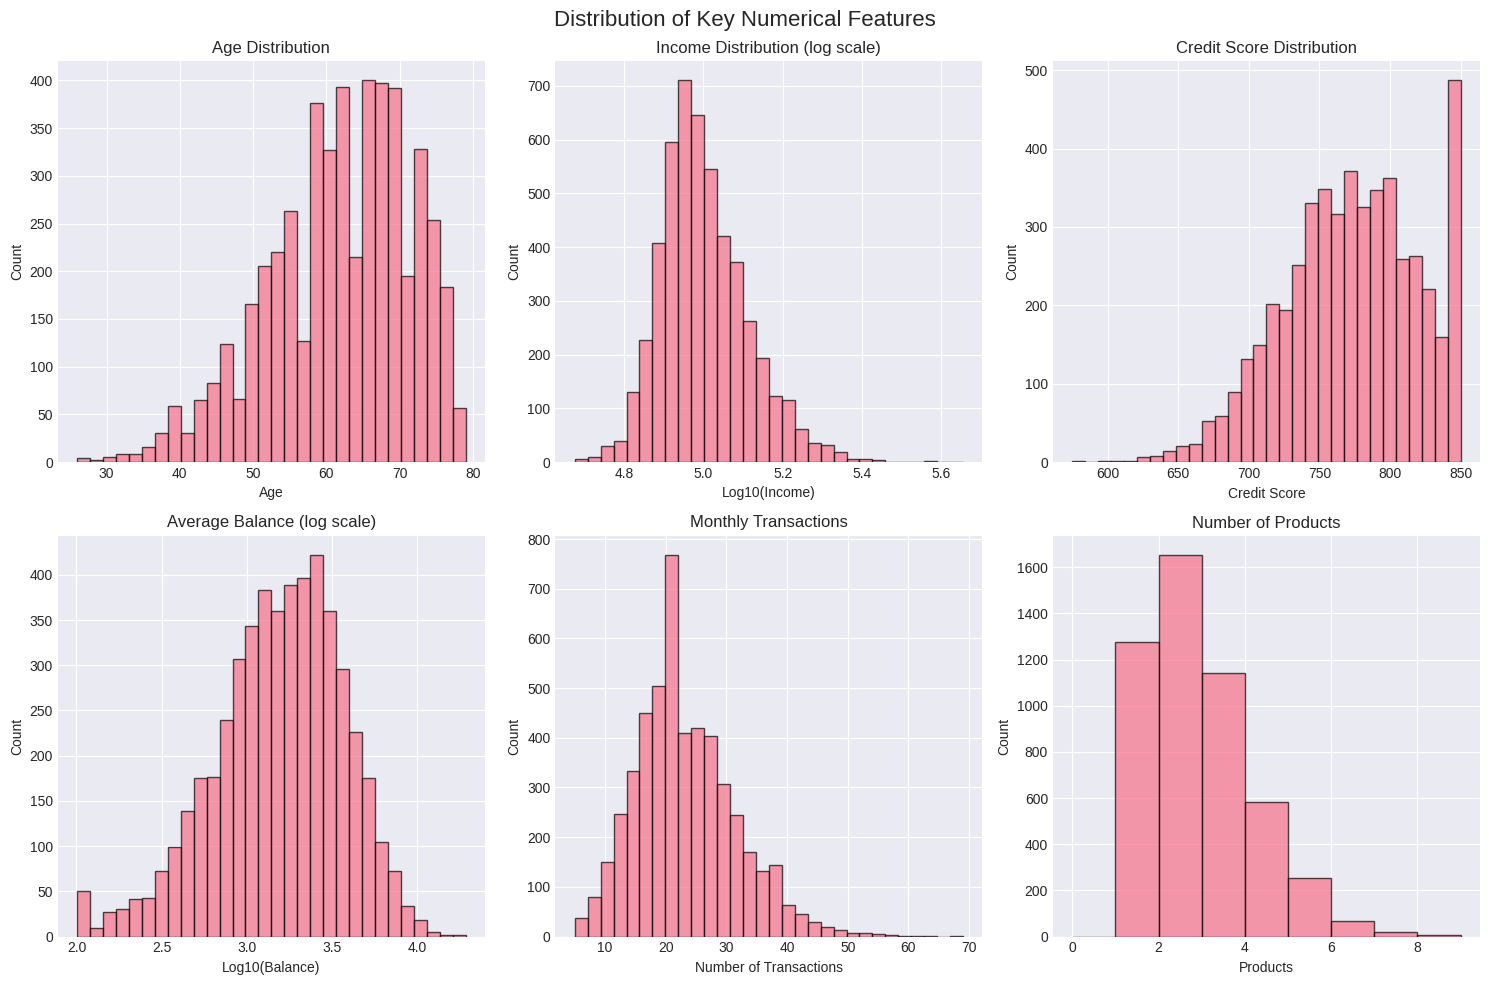

In [17]:
# %% [markdown]
# ### 3.1 Data Quality Check

# %%
# Check for data quality
print("🔍 Data Quality Check:")
print("-" * 50)

# Missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ No missing values found")
else:
    print("❌ Missing values detected:")
    print(missing_values[missing_values > 0])

# Duplicates
duplicates = df.duplicated().sum()
print(f"\n📋 Duplicate rows: {duplicates}")

# Data types
print("\n📝 Data Types:")
print(df.dtypes.value_counts())

# Basic statistics
print("\n📈 Basic Statistics:")
df.describe()

# %%
# Visualize data distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16)

# Age distribution
axes[0, 0].hist(df['age'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')

# Income distribution (log scale)
axes[0, 1].hist(np.log10(df['income']), bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Income Distribution (log scale)')
axes[0, 1].set_xlabel('Log10(Income)')
axes[0, 1].set_ylabel('Count')

# Credit score distribution
axes[0, 2].hist(df['credit_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Credit Score Distribution')
axes[0, 2].set_xlabel('Credit Score')
axes[0, 2].set_ylabel('Count')

# Account balance distribution (log scale)
axes[1, 0].hist(np.log10(df['avg_balance'] + 1), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Average Balance (log scale)')
axes[1, 0].set_xlabel('Log10(Balance)')
axes[1, 0].set_ylabel('Count')

# Monthly transactions
axes[1, 1].hist(df['monthly_transactions'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Monthly Transactions')
axes[1, 1].set_xlabel('Number of Transactions')
axes[1, 1].set_ylabel('Count')

# Number of products
axes[1, 2].hist(df['num_products'], bins=range(0, 10), edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Number of Products')
axes[1, 2].set_xlabel('Products')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()




# %% [markdown]
# ## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>



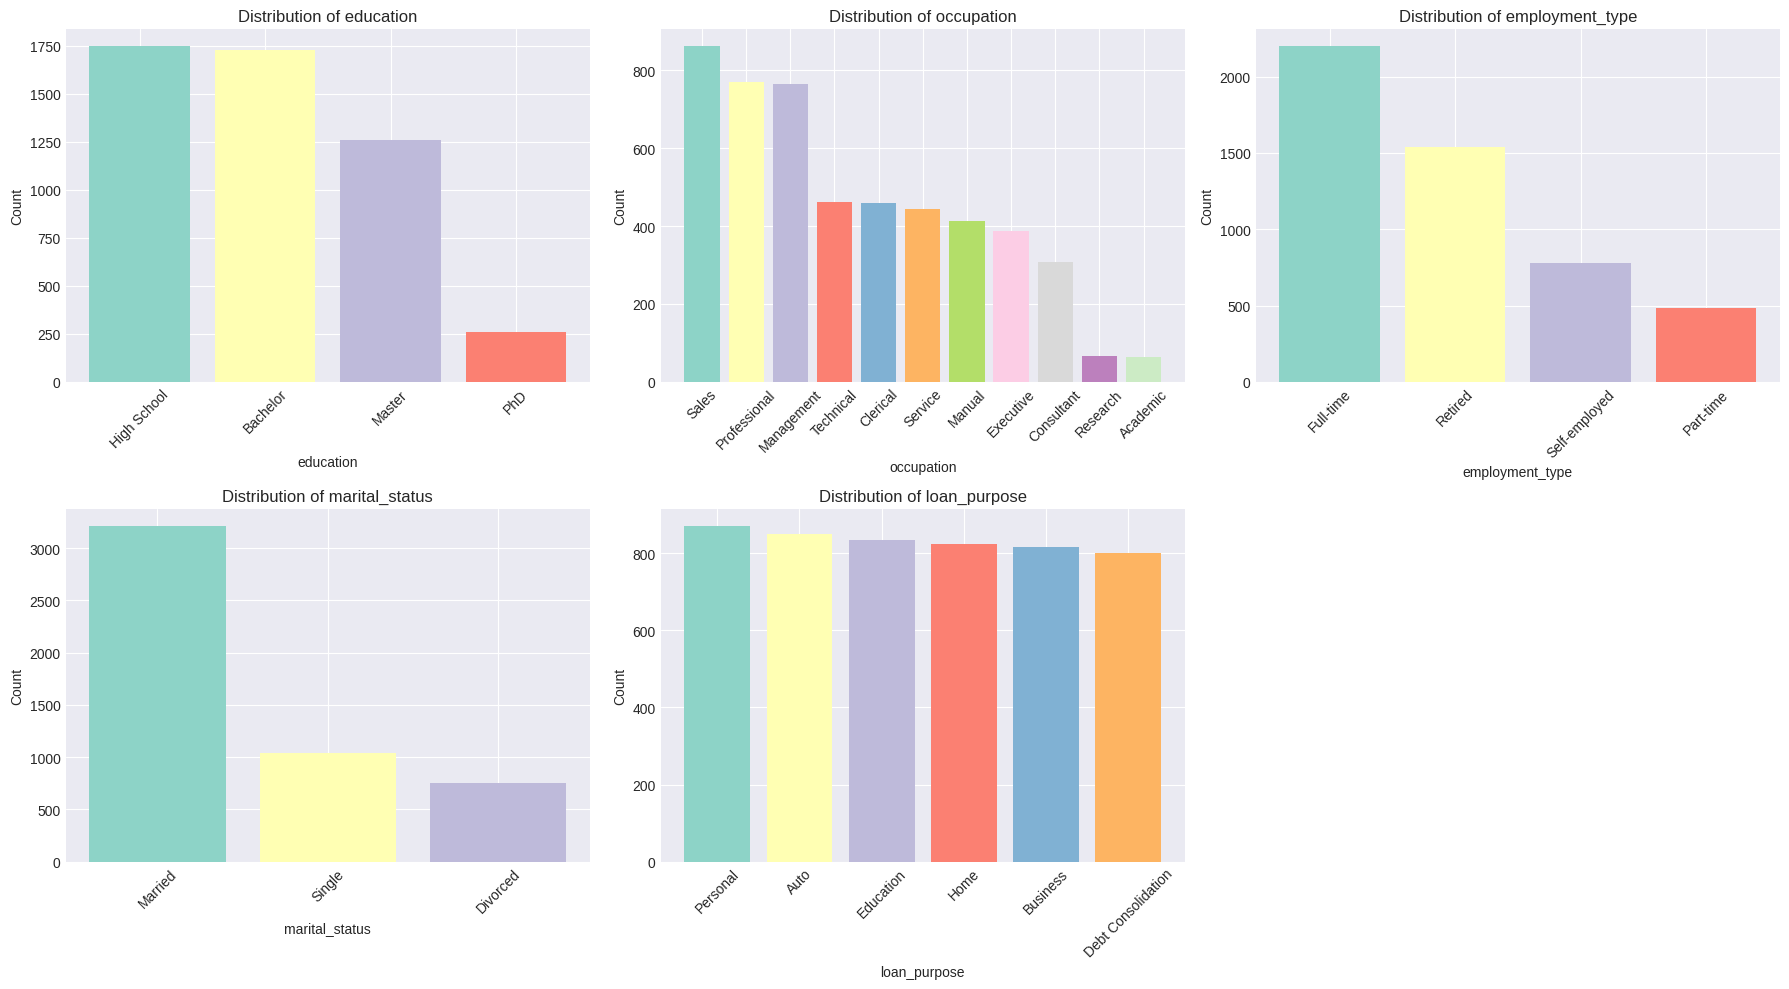

In [21]:
# %%
# Categorical variable distributions
categorical_cols = ['education', 'occupation', 'employment_type', 'marital_status', 'loan_purpose']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].bar(value_counts.index, value_counts.values, color=plt.cm.Set3(range(len(value_counts))))
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


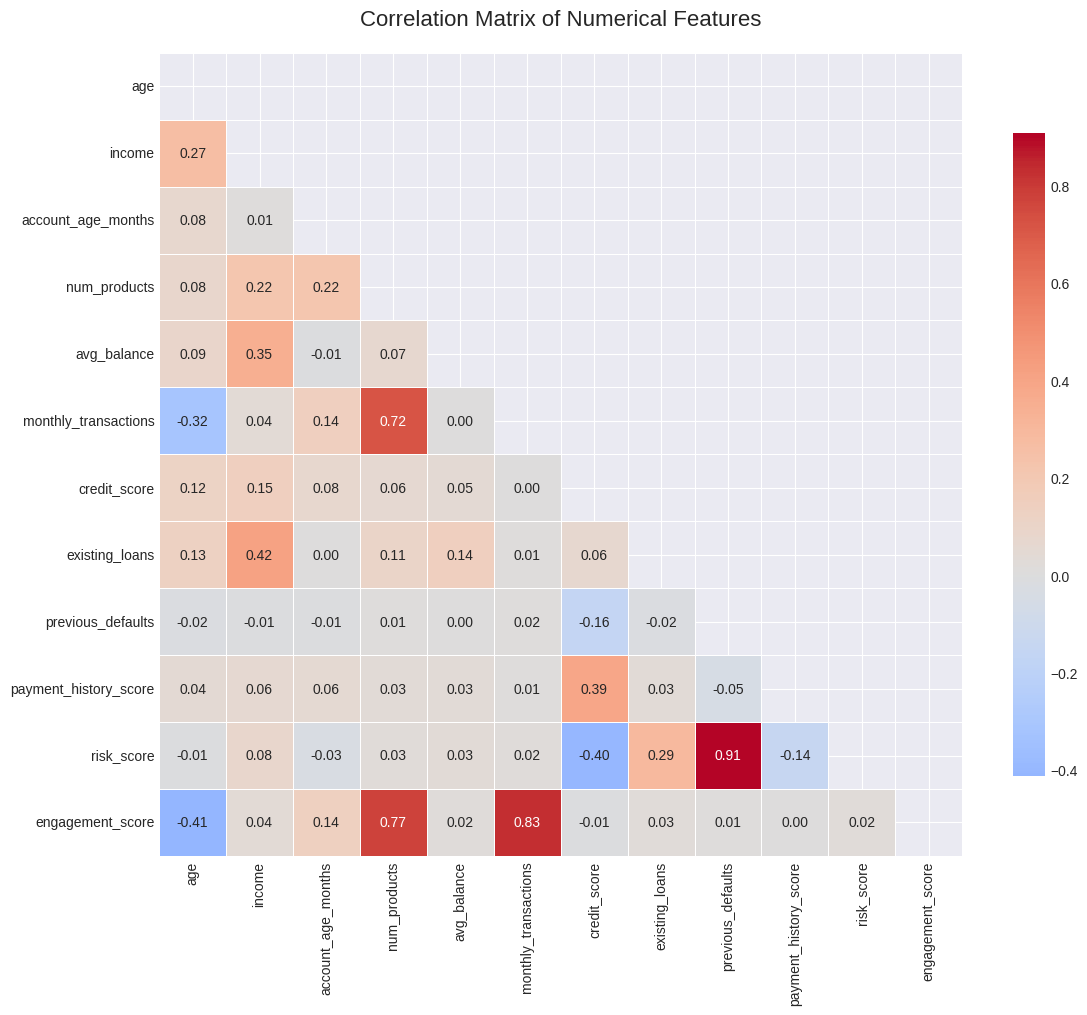

In [27]:
# %%
# Correlation analysis
# Select numerical features for correlation
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance',
                     'monthly_transactions', 'credit_score', 'existing_loans', 'previous_defaults',
                     'payment_history_score', 'risk_score', 'engagement_score']
# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

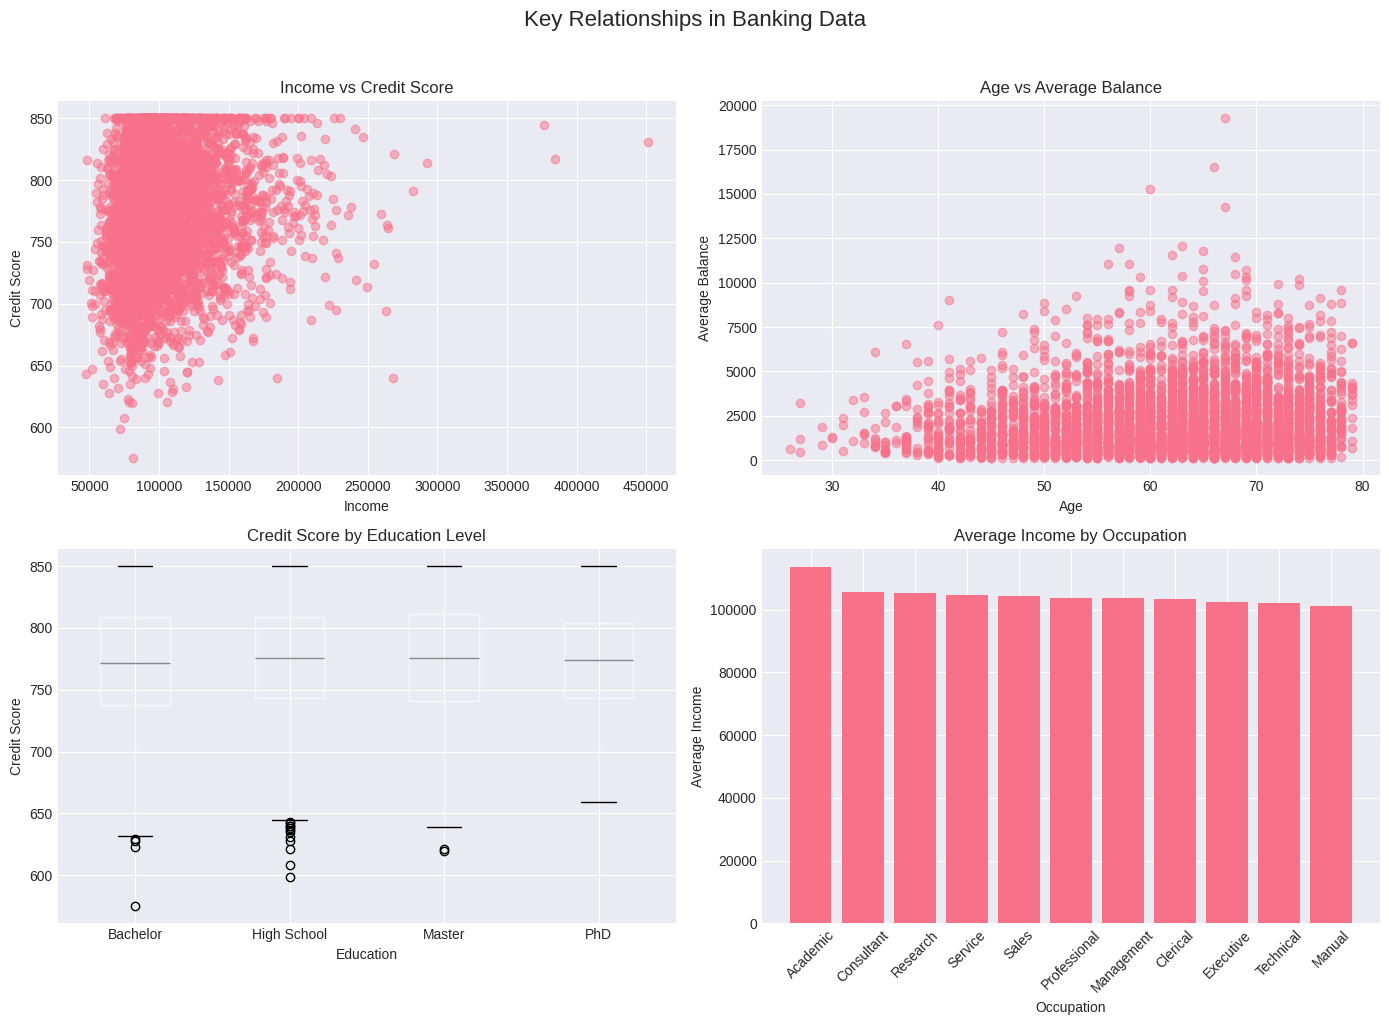

In [28]:
# %%
# Analyze relationships between key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Income vs Credit Score
axes[0, 0].scatter(df['income'], df['credit_score'], alpha=0.5)
axes[0, 0].set_xlabel('Income')
axes[0, 0].set_ylabel('Credit Score')
axes[0, 0].set_title('Income vs Credit Score')

# Age vs Account Balance
axes[0, 1].scatter(df['age'], df['avg_balance'], alpha=0.5)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Average Balance')
axes[0, 1].set_title('Age vs Average Balance')

# Credit Score by Education
df.boxplot(column='credit_score', by='education', ax=axes[1, 0])
axes[1, 0].set_title('Credit Score by Education Level')
axes[1, 0].set_xlabel('Education')
axes[1, 0].set_ylabel('Credit Score')

# Income by Occupation
occupation_income = df.groupby('occupation')['income'].mean().sort_values(ascending=False)
axes[1, 1].bar(occupation_income.index, occupation_income.values)
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Average Income')
axes[1, 1].set_title('Average Income by Occupation')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Key Relationships in Banking Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [30]:


# %% [markdown]
# ## 5. Data Preprocessing <a id='preprocessing'></a>

# %%
# Create a copy for preprocessing
df_processed = df.copy()

# Identify feature types
categorical_features = ['education', 'occupation', 'employment_type', 'marital_status', 'loan_purpose']
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance',
                     'max_balance', 'monthly_transactions', 'avg_transaction_amount',
                     'max_transaction_amount', 'digital_usage_rate', 'credit_score',
                     'existing_loans', 'previous_defaults', 'payment_history_score',
                     'loan_amount_requested', 'loan_term_months', 'total_relationship_value',
                     'risk_score', 'engagement_score']

# Features to exclude from clustering (identifiers and derived features)
exclude_features = ['customer_id']

print(f"📊 Feature Summary:")
print(f"- Categorical features: {len(categorical_features)}")
print(f"- Numerical features: {len(numerical_features)}")
print(f"- Excluded features: {len(exclude_features)}")

📊 Feature Summary:
- Categorical features: 5
- Numerical features: 19
- Excluded features: 1


In [31]:


# %% [markdown]
# ### 5.1 Feature Engineering

# %%
# Create additional features that might be useful for segmentation
print("🛠️ Creating engineered features...")

# Financial ratios
df_processed['balance_to_income_ratio'] = df_processed['avg_balance'] / (df_processed['income'] / 12)
df_processed['loan_to_income_ratio'] = df_processed['loan_amount_requested'] / df_processed['income']
df_processed['transaction_diversity'] = (df_processed['avg_transaction_amount'] /
                                        (df_processed['max_transaction_amount'] + 1))

# Behavioral indicators
df_processed['products_per_year'] = df_processed['num_products'] / (df_processed['account_age_months'] / 12 + 1)
df_processed['high_value_customer'] = ((df_processed['avg_balance'] > df_processed['avg_balance'].quantile(0.75)) &
                                       (df_processed['num_products'] >= 3)).astype(int)

# Risk indicators
df_processed['high_risk_flag'] = ((df_processed['credit_score'] < 600) |
                                  (df_processed['previous_defaults'] > 0) |
                                  (df_processed['risk_score'] > df_processed['risk_score'].quantile(0.8))).astype(int)

# Age groups
df_processed['age_group'] = pd.cut(df_processed['age'],
                                   bins=[0, 25, 35, 50, 65, 100],
                                   labels=['Gen Z', 'Millennial', 'Gen X', 'Boomer', 'Senior'])

# Income segments
df_processed['income_segment'] = pd.qcut(df_processed['income'],
                                         q=5,
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Update feature lists
new_numerical_features = ['balance_to_income_ratio', 'loan_to_income_ratio',
                         'transaction_diversity', 'products_per_year']
new_categorical_features = ['age_group', 'income_segment']

numerical_features.extend(new_numerical_features)
categorical_features.extend(new_categorical_features)

print("✅ Feature engineering complete!")
print(f"New numerical features: {new_numerical_features}")
print(f"New categorical features: {new_categorical_features}")

# %%
# Check for any missing values created during feature engineering
missing_after_fe = df_processed.isnull().sum()
if missing_after_fe.sum() > 0:
    print("⚠️ Missing values after feature engineering:")
    print(missing_after_fe[missing_after_fe > 0])

    # Handle infinities and NaN values
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
    df_processed[numerical_features] = df_processed[numerical_features].fillna(
        df_processed[numerical_features].median()
    )
else:
    print("✅ No missing values after feature engineering")

🛠️ Creating engineered features...
✅ Feature engineering complete!
New numerical features: ['balance_to_income_ratio', 'loan_to_income_ratio', 'transaction_diversity', 'products_per_year']
New categorical features: ['age_group', 'income_segment']
✅ No missing values after feature engineering


🔍 Outlier Detection Results:
- income: 200 outliers (4.00%)
- avg_balance: 217 outliers (4.34%)
- monthly_transactions: 80 outliers (1.60%)
- loan_amount_requested: 63 outliers (1.26%)


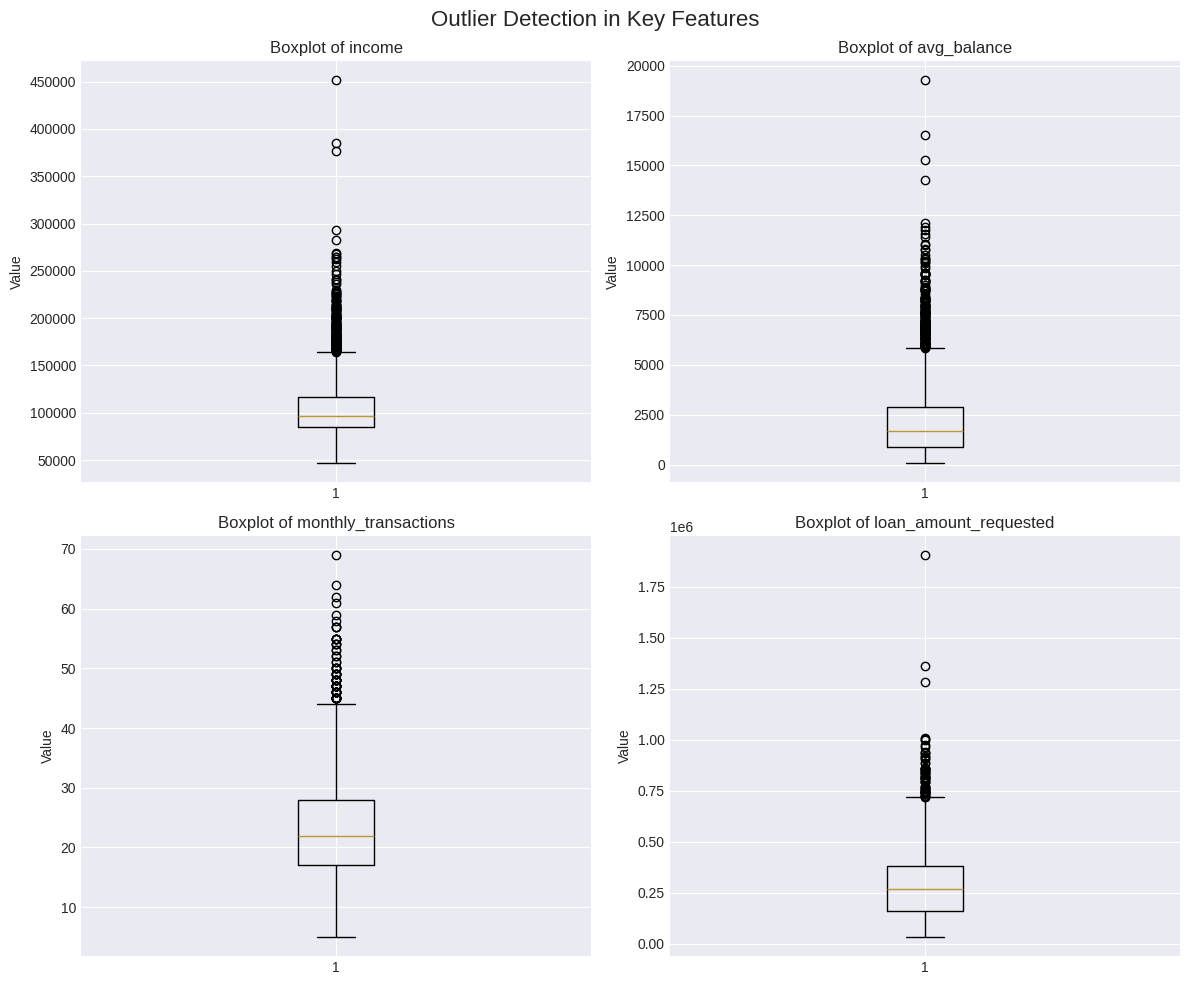

In [32]:
# %% [markdown]
# ### 5.2 Outlier Detection and Treatment

# %%
# Detect outliers using IQR method
def detect_outliers_iqr(data, columns, threshold=1.5):
    """Detect outliers using the IQR method"""
    outlier_indices = {}

    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index

        if len(outliers) > 0:
            outlier_indices[col] = outliers

    return outlier_indices

# Detect outliers in key numerical features
key_features_for_outliers = ['income', 'avg_balance', 'monthly_transactions', 'loan_amount_requested']
outliers = detect_outliers_iqr(df_processed, key_features_for_outliers)

print("🔍 Outlier Detection Results:")
for feature, indices in outliers.items():
    print(f"- {feature}: {len(indices)} outliers ({len(indices)/len(df_processed)*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features_for_outliers):
    axes[idx].boxplot(df_processed[feature])
    axes[idx].set_title(f'Boxplot of {feature}')
    axes[idx].set_ylabel('Value')

plt.suptitle('Outlier Detection in Key Features', fontsize=16)
plt.tight_layout()
plt.show()


In [33]:
# %% [markdown]
# ### 5.3 Data Transformation Pipeline

# %%
# Create preprocessing pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer

# For clustering, we'll use RobustScaler (less sensitive to outliers) for numerical features
# and OneHotEncoder for categorical features

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'  # Drop columns not specified
)

# Prepare data for clustering (exclude customer_id and target-like variables)
clustering_features = [col for col in numerical_features + categorical_features
                      if col not in exclude_features]

X_clustering = df_processed[clustering_features]

print("🔄 Applying preprocessing pipeline...")
X_transformed = preprocessor.fit_transform(X_clustering)

# Get feature names after transformation
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

print(f"✅ Data transformed successfully!")
print(f"Original shape: {X_clustering.shape}")
print(f"Transformed shape: {X_transformed.shape}")
print(f"Number of features after encoding: {len(all_feature_names)}")

🔄 Applying preprocessing pipeline...
✅ Data transformed successfully!
Original shape: (5000, 30)
Transformed shape: (5000, 53)
Number of features after encoding: 53


# %% [markdown]
# ## 6. Customer Segmentation <a id='segmentation'></a>

In [35]:
# %% [markdown]
# ### 6.1 Determining Optimal Number of Clusters

# %%
# Function to evaluate clustering for different numbers of clusters
def evaluate_clustering(X, max_clusters=10):
    """
    Evaluate clustering performance for different numbers of clusters
    """
    results = {
        'n_clusters': [],
        'inertia': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': []
    }

    K_range = range(2, max_clusters + 1)

    for k in K_range:
        print(f"Evaluating k={k}...", end='\r')

        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Calculate metrics
        results['n_clusters'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(X, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X, labels))

    return pd.DataFrame(results)

🔄 Evaluating different numbers of clusters...

✅ Evaluation complete!

📊 Clustering Evaluation Metrics:
 n_clusters      inertia  silhouette  davies_bouldin  calinski_harabasz
          2 88647.281596    0.222500        1.990466         815.474109
          3 79897.902952    0.233210        1.708305         725.899805
          4 74514.653118    0.112959        2.209890         639.101883
          5 70636.979407    0.106545        2.155307         574.088929
          6 67640.698685    0.083913        2.211209         523.763316
          7 65845.963587    0.082761        2.273918         470.959872
          8 64336.359368    0.081972        2.334469         429.801185
          9 62925.590194    0.081087        2.272713         398.417857
         10 61640.813408    0.079310        2.228473         373.014275


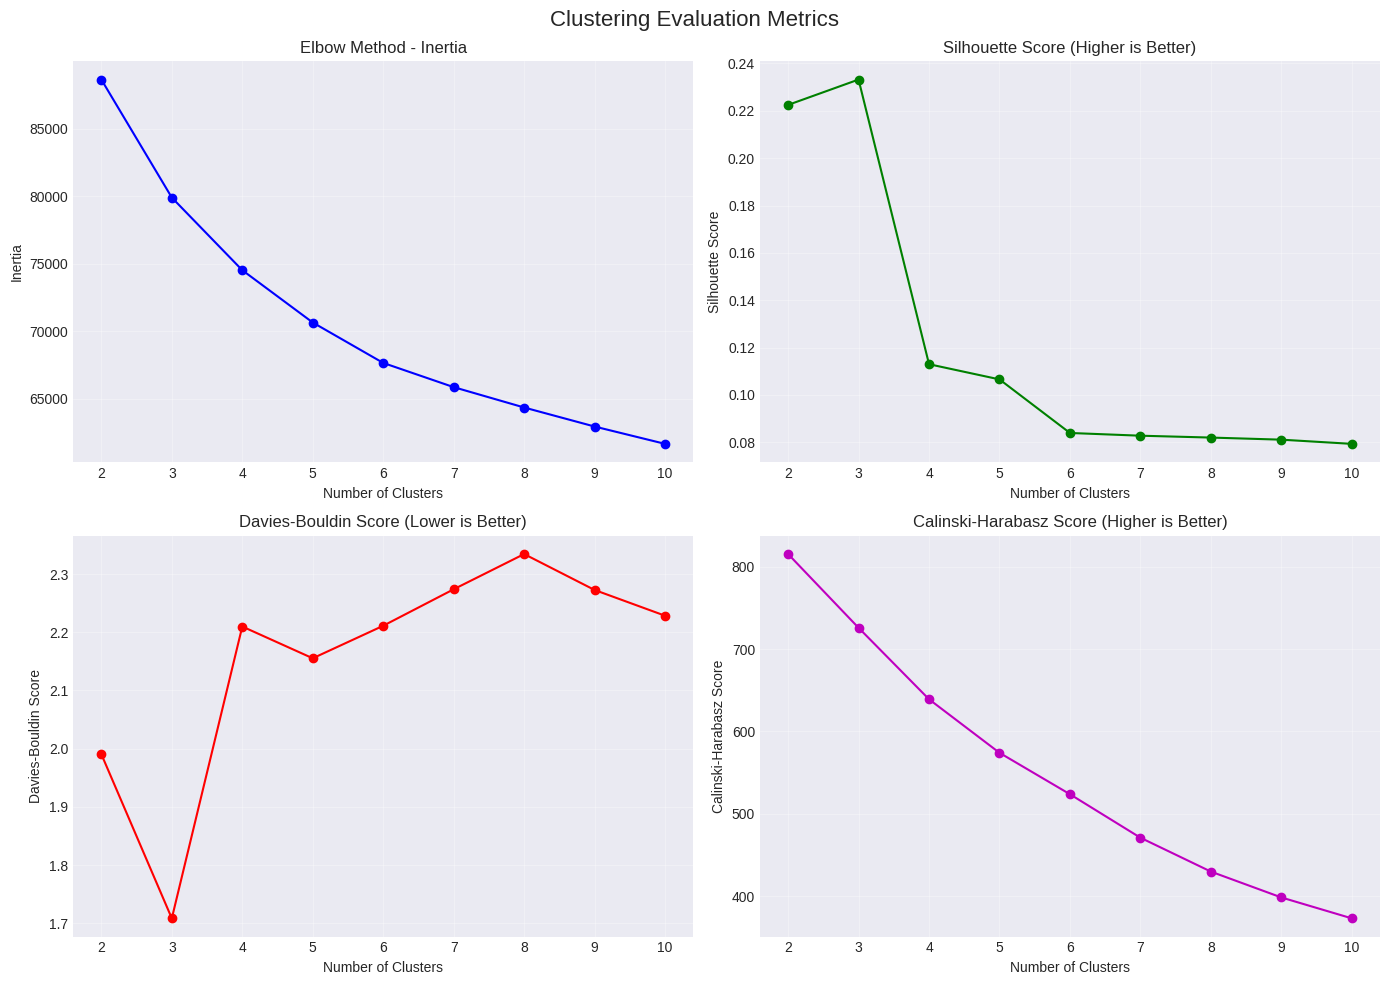

In [36]:

# Evaluate clustering
print("🔄 Evaluating different numbers of clusters...")
cluster_evaluation = evaluate_clustering(X_transformed, max_clusters=10)
print("\n✅ Evaluation complete!")

# Display results
print("\n📊 Clustering Evaluation Metrics:")
print(cluster_evaluation.to_string(index=False))

# %%
# Visualize clustering evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow plot (Inertia)
axes[0, 0].plot(cluster_evaluation['n_clusters'], cluster_evaluation['inertia'], 'bo-')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method - Inertia')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(cluster_evaluation['n_clusters'], cluster_evaluation['silhouette'], 'go-')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin Score
axes[1, 0].plot(cluster_evaluation['n_clusters'], cluster_evaluation['davies_bouldin'], 'ro-')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[1, 1].plot(cluster_evaluation['n_clusters'], cluster_evaluation['calinski_harabasz'], 'mo-')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Clustering Evaluation Metrics', fontsize=16)
plt.tight_layout()
plt.show()

In [37]:




# %%
# Determine optimal number of clusters based on multiple criteria
# Find the elbow point in inertia
inertia_values = cluster_evaluation['inertia'].values
n_clusters_range = cluster_evaluation['n_clusters'].values

# Calculate rate of change
rate_of_change = np.diff(inertia_values) / np.diff(n_clusters_range)
rate_of_change_2nd = np.diff(rate_of_change)

# Find elbow (maximum second derivative)
elbow_idx = np.argmax(rate_of_change_2nd) + 2  # +2 because of double diff

# Get best cluster based on silhouette score
best_silhouette_idx = cluster_evaluation['silhouette'].idxmax()
best_silhouette_k = cluster_evaluation.loc[best_silhouette_idx, 'n_clusters']

print("📊 Optimal Cluster Analysis:")
print(f"- Elbow method suggests: {n_clusters_range[elbow_idx]} clusters")
print(f"- Best silhouette score: {best_silhouette_k} clusters (score: {cluster_evaluation.loc[best_silhouette_idx, 'silhouette']:.3f})")
print(f"- Best Davies-Bouldin score: {cluster_evaluation.loc[cluster_evaluation['davies_bouldin'].idxmin(), 'n_clusters']} clusters")

# Choose optimal number of clusters (we'll use silhouette score as primary metric)
optimal_clusters = best_silhouette_k
print(f"\n✅ Selected optimal number of clusters: {optimal_clusters}")

📊 Optimal Cluster Analysis:
- Elbow method suggests: 4 clusters
- Best silhouette score: 3 clusters (score: 0.233)
- Best Davies-Bouldin score: 3 clusters

✅ Selected optimal number of clusters: 3


In [38]:
# %% [markdown]
# ### 6.2 Perform K-Means Clustering

# %%
# Perform final clustering with optimal number of clusters
print(f"🔄 Performing K-Means clustering with {optimal_clusters} clusters...")

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=20, max_iter=300)
cluster_labels = final_kmeans.fit_predict(X_transformed)

# Add cluster labels to original dataframe
df_processed['cluster'] = cluster_labels

print("✅ Clustering complete!")
print(f"Cluster distribution:")
print(df_processed['cluster'].value_counts().sort_index())

# Calculate final metrics
final_silhouette = silhouette_score(X_transformed, cluster_labels)
final_davies_bouldin = davies_bouldin_score(X_transformed, cluster_labels)

print(f"\n📊 Final Clustering Metrics:")
print(f"- Silhouette Score: {final_silhouette:.3f}")
print(f"- Davies-Bouldin Score: {final_davies_bouldin:.3f}")


🔄 Performing K-Means clustering with 3 clusters...
✅ Clustering complete!
Cluster distribution:
cluster
0     827
1     378
2    3795
Name: count, dtype: int64

📊 Final Clustering Metrics:
- Silhouette Score: 0.233
- Davies-Bouldin Score: 1.710


🔄 Reducing dimensions for visualization...


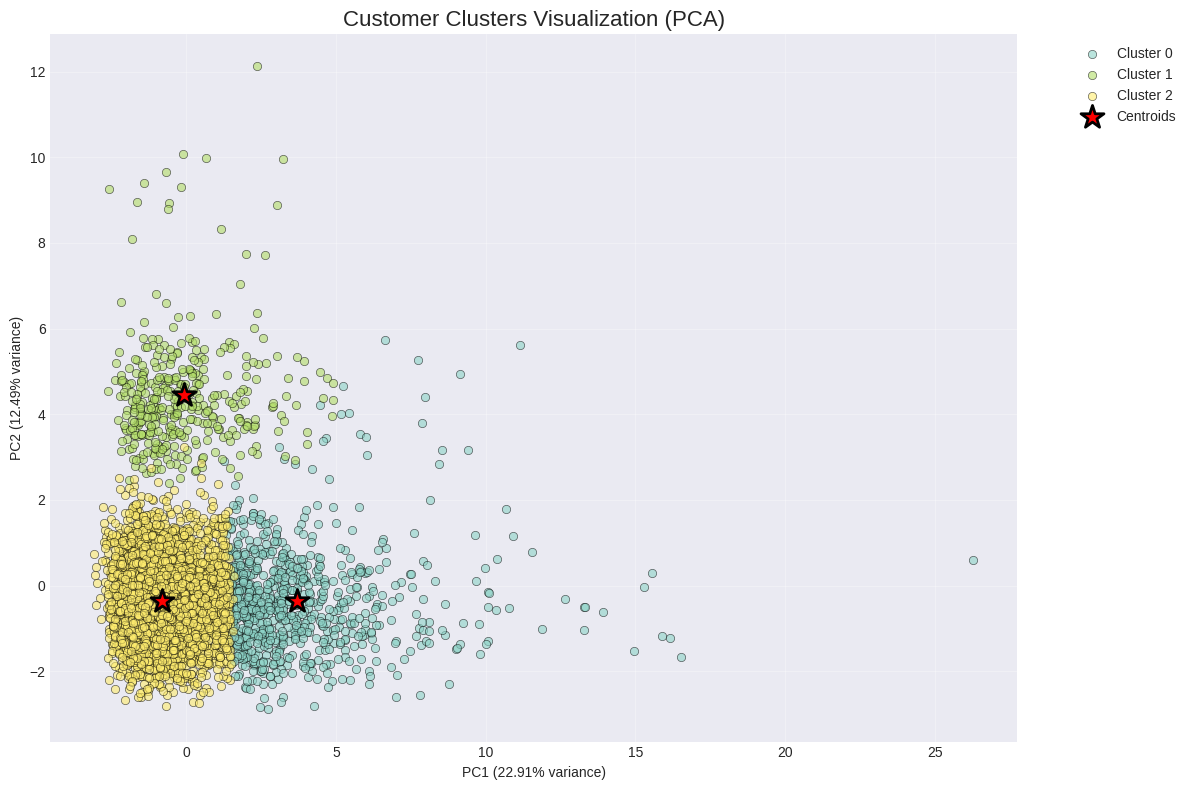

✅ Total variance explained by 2 PCs: 35.40%


In [40]:
# %% [markdown]
# ### 6.3 Visualize Clusters

# %%
# Reduce dimensions for visualization using PCA
print("🔄 Reducing dimensions for visualization...")

# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Create visualization
plt.figure(figsize=(12, 8))

# Plot each cluster
colors = plt.cm.Set3(np.linspace(0, 1, optimal_clusters))
for i in range(optimal_clusters):
    mask = cluster_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[i]], label=f'Cluster {i}',
               alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot centroids
centroids_pca = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           marker='*', s=300, c='red', edgecolor='black', linewidth=2,
           label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Clusters Visualization (PCA)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_):.2%}")


🔄 Creating t-SNE visualization (this may take a moment)...


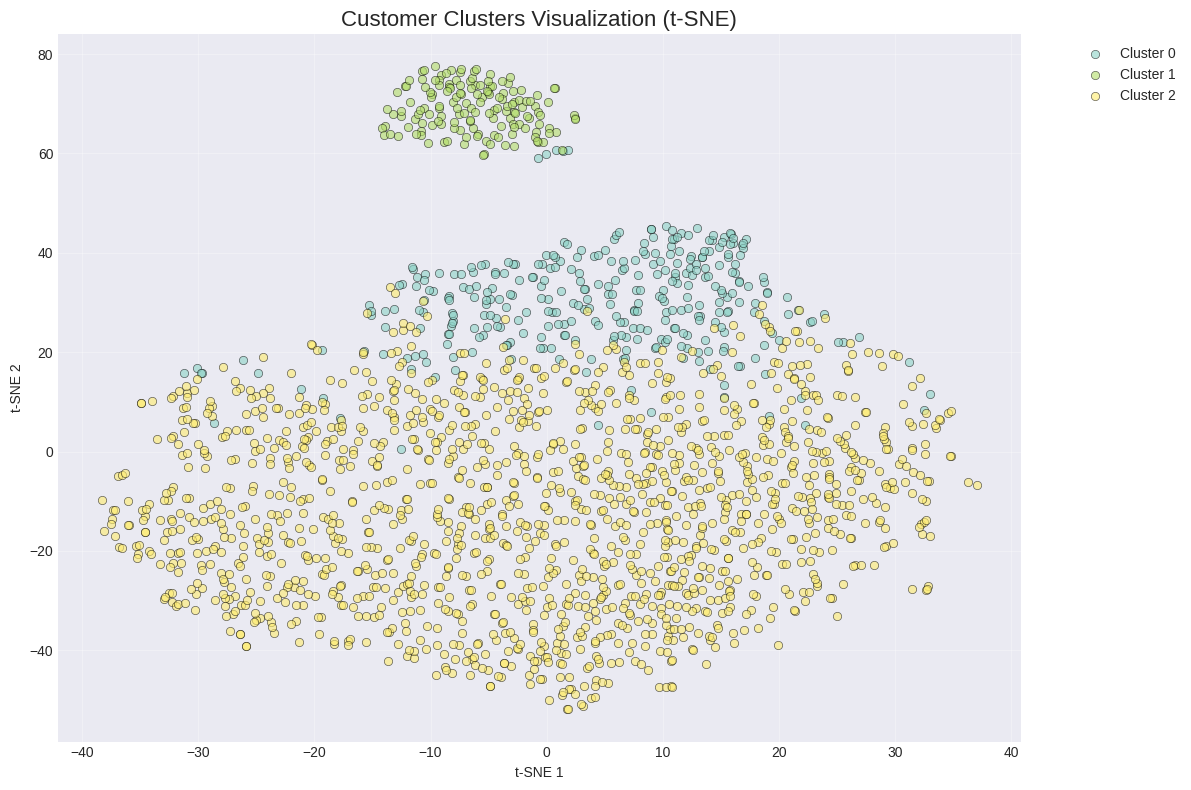

In [41]:

# %%
# Alternative visualization using t-SNE for better cluster separation
print("🔄 Creating t-SNE visualization (this may take a moment)...")

# Sample data if too large (t-SNE is computationally expensive)
if len(X_transformed) > 2000:
    sample_idx = np.random.choice(len(X_transformed), 2000, replace=False)
    X_sample = X_transformed[sample_idx]
    labels_sample = cluster_labels[sample_idx]
else:
    X_sample = X_transformed
    labels_sample = cluster_labels

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

# Create visualization
plt.figure(figsize=(12, 8))

for i in range(optimal_clusters):
    mask = labels_sample == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=[colors[i]], label=f'Cluster {i}',
               alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Customer Clusters Visualization (t-SNE)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:


# %% [markdown]
# ## 7. Segment Analysis and Profiling <a id='segment-analysis'></a>

# %% [markdown]
# ### 7.1 Statistical Profiling of Segments

# %%
# Create comprehensive segment profiles
def create_segment_profiles(df, numerical_cols, categorical_cols):
    """Create detailed profiles for each segment"""

    profiles = []

    for cluster in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster]

        profile = {
            'cluster': cluster,
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df) * 100
        }

        # Numerical features - mean and std
        for col in numerical_cols:
            if col in df.columns:
                profile[f'{col}_mean'] = cluster_data[col].mean()
                profile[f'{col}_std'] = cluster_data[col].std()

        # Categorical features - mode
        for col in categorical_cols:
            if col in df.columns:
                mode_value = cluster_data[col].mode()
                if len(mode_value) > 0:
                    profile[f'{col}_mode'] = mode_value[0]
                    profile[f'{col}_mode_pct'] = (cluster_data[col] == mode_value[0]).mean() * 100

        profiles.append(profile)

    return pd.DataFrame(profiles)

In [45]:


# Key features for profiling
key_numerical = ['age', 'income', 'avg_balance', 'credit_score', 'monthly_transactions',
                'num_products', 'risk_score', 'engagement_score']
key_categorical = ['education', 'occupation', 'marital_status', 'employment_type']

# Create profiles
segment_profiles = create_segment_profiles(df_processed, key_numerical, key_categorical)

# Display key metrics for each segment
print("📊 Segment Profiles - Key Metrics:")
display_cols = ['cluster', 'size', 'percentage', 'age_mean', 'income_mean',
                'avg_balance_mean', 'credit_score_mean', 'num_products_mean']
print(segment_profiles[display_cols].round(2).to_string(index=False))

📊 Segment Profiles - Key Metrics:
 cluster  size  percentage  age_mean  income_mean  avg_balance_mean  credit_score_mean  num_products_mean
       0   827       16.54     65.15    118989.25           4897.10             778.38               2.19
       1   378        7.56     60.89    100637.65           1944.34             748.13               2.48
       2  3795       75.90     61.25    100661.27           1571.58             774.65               2.49


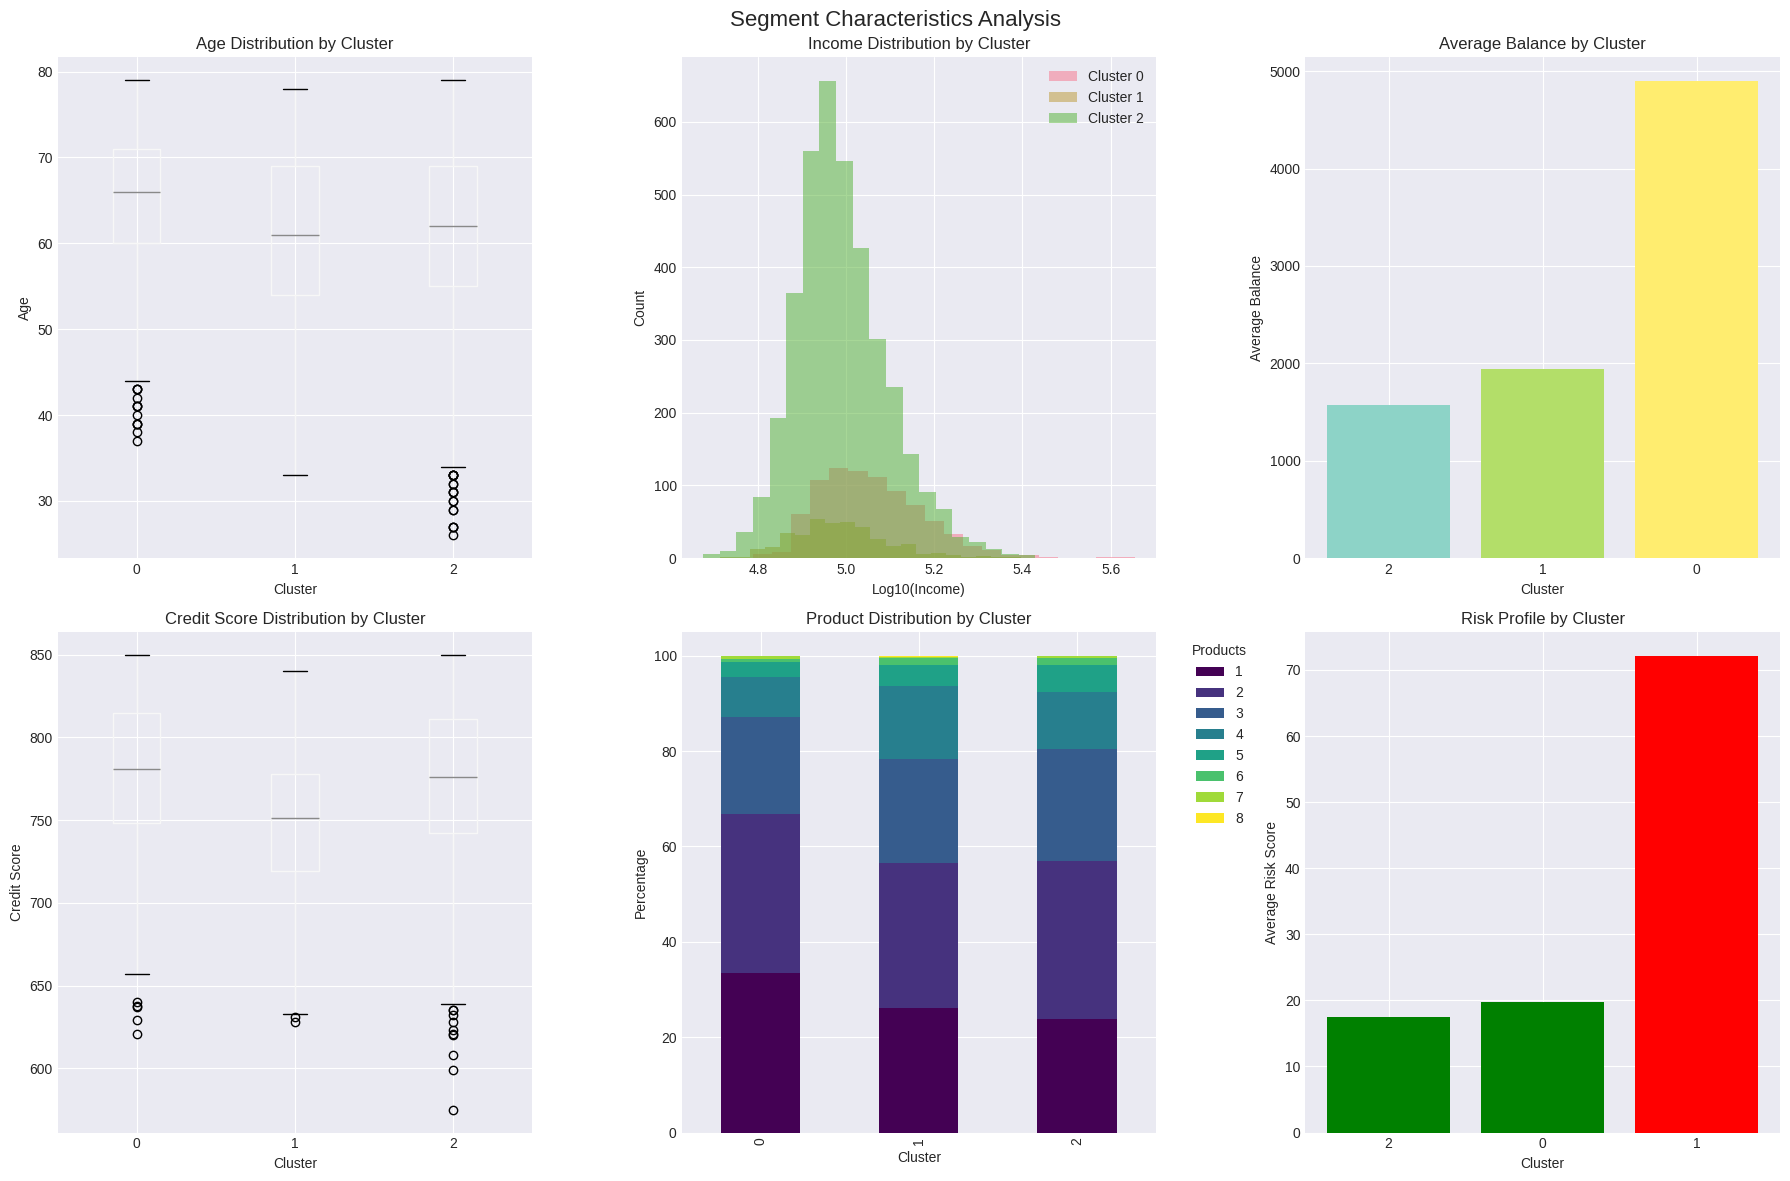

In [48]:

# %%
# Visualize segment characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot 1: Age distribution by cluster
df_processed.boxplot(column='age', by='cluster', ax=axes[0])
axes[0].set_title('Age Distribution by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Age')

# Plot 2: Income distribution by cluster (log scale)
for cluster in sorted(df_processed['cluster'].unique()):
    cluster_data = df_processed[df_processed['cluster'] == cluster]
    axes[1].hist(np.log10(cluster_data['income']), alpha=0.5, label=f'Cluster {cluster}', bins=20)
axes[1].set_xlabel('Log10(Income)')
axes[1].set_ylabel('Count')
axes[1].set_title('Income Distribution by Cluster')
axes[1].legend()

# Plot 3: Average balance by cluster
cluster_avg_balance = df_processed.groupby('cluster')['avg_balance'].mean().sort_values()
axes[2].bar(cluster_avg_balance.index.astype(str), cluster_avg_balance.values,
            color=colors[:len(cluster_avg_balance)])
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Average Balance')
axes[2].set_title('Average Balance by Cluster')

# Plot 4: Credit score by cluster
df_processed.boxplot(column='credit_score', by='cluster', ax=axes[3])
axes[3].set_title('Credit Score Distribution by Cluster')
axes[3].set_xlabel('Cluster')
axes[3].set_ylabel('Credit Score')

# Plot 5: Number of products by cluster
product_dist = df_processed.groupby(['cluster', 'num_products']).size().unstack(fill_value=0)
product_dist_pct = product_dist.div(product_dist.sum(axis=1), axis=0) * 100
product_dist_pct.plot(kind='bar', stacked=True, ax=axes[4], colormap='viridis')
axes[4].set_xlabel('Cluster')
axes[4].set_ylabel('Percentage')
axes[4].set_title('Product Distribution by Cluster')
axes[4].legend(title='Products', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 6: Risk score by cluster
cluster_risk = df_processed.groupby('cluster')['risk_score'].mean().sort_values()
axes[5].bar(cluster_risk.index.astype(str), cluster_risk.values,
            color=['green' if x < 30 else 'orange' if x < 50 else 'red' for x in cluster_risk.values])
axes[5].set_xlabel('Cluster')
axes[5].set_ylabel('Average Risk Score')
axes[5].set_title('Risk Profile by Cluster')

plt.suptitle('Segment Characteristics Analysis', fontsize=16)
plt.tight_layout()
plt.show()

📋 Segment Summary:
 Cluster       Segment Name                                            Description  Size  Percentage
       0 Standard Segment 0 Regular banking customers with average characteristics   827        16.5
       1 Standard Segment 1 Regular banking customers with average characteristics   378         7.6
       2 Standard Segment 2 Regular banking customers with average characteristics  3795        75.9


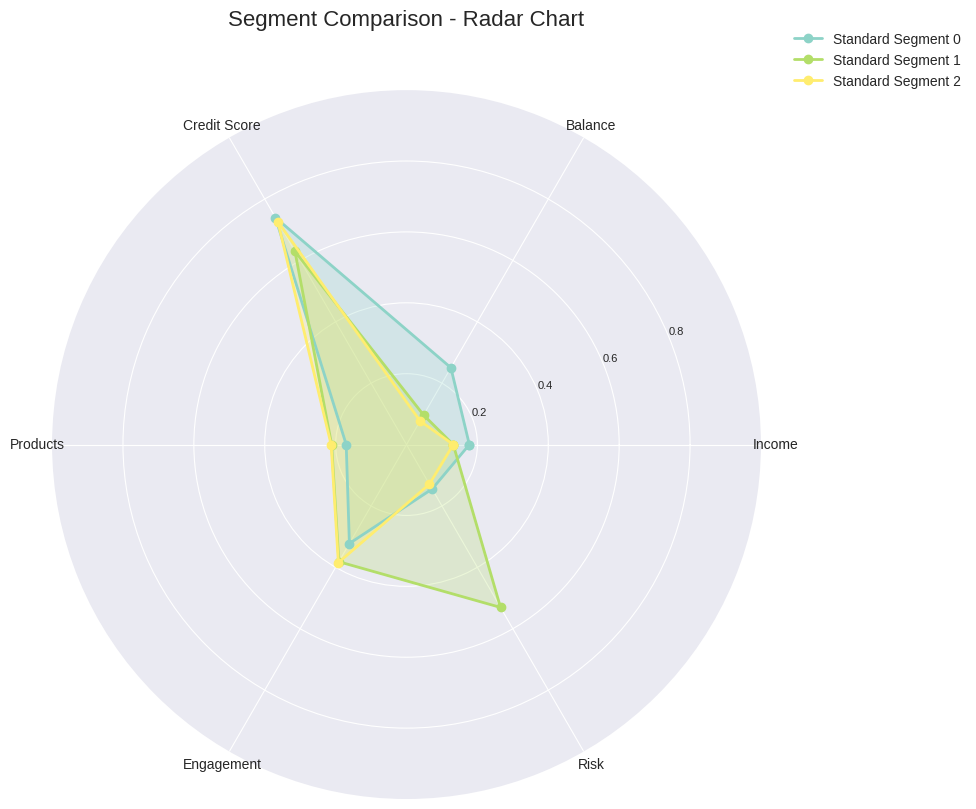

In [50]:

# %% [markdown]
# ### 7.2 Segment Naming and Business Interpretation

# %%
# Analyze segments to assign meaningful names
def analyze_and_name_segments(df, profiles):
    """Analyze segments and assign business-meaningful names"""

    segment_names = {}
    segment_descriptions = {}

    for idx, row in profiles.iterrows():
        cluster = row['cluster']
        cluster_data = df[df['cluster'] == cluster]

        # Analyze key characteristics
        avg_age = row['age_mean']
        avg_income = row['income_mean']
        avg_balance = row['avg_balance_mean']
        avg_credit = row['credit_score_mean']
        avg_products = row['num_products_mean']
        avg_risk = row['risk_score_mean']

        # Determine segment name based on characteristics
        if avg_income > 100000 and avg_balance > 50000 and avg_credit > 750:
            name = "Premium High-Value"
            desc = "High-income, high-balance customers with excellent credit"
        elif avg_age < 30 and avg_products < 2:
            name = "Young Starters"
            desc = "Young customers just beginning their banking relationship"
        elif avg_risk > 50 and avg_credit < 600:
            name = "High Risk"
            desc = "Customers with poor credit and high risk indicators"
        elif avg_products > 4 and avg_balance > 20000:
            name = "Engaged Multi-Product"
            desc = "Highly engaged customers using multiple banking products"
        elif avg_age > 50 and avg_balance > 30000:
            name = "Mature Savers"
            desc = "Older customers with substantial savings"
        else:
            name = f"Standard Segment {cluster}"
            desc = "Regular banking customers with average characteristics"

        segment_names[cluster] = name
        segment_descriptions[cluster] = desc

    return segment_names, segment_descriptions


# Analyze and name segments
segment_names, segment_descriptions = analyze_and_name_segments(df_processed, segment_profiles)

# Create segment summary
segment_summary = pd.DataFrame({
    'Cluster': list(segment_names.keys()),
    'Segment Name': list(segment_names.values()),
    'Description': list(segment_descriptions.values()),
    'Size': segment_profiles['size'].values,
    'Percentage': segment_profiles['percentage'].values.round(1)
})

print("📋 Segment Summary:")
print(segment_summary.to_string(index=False))

# Add segment names to dataframe
df_processed['segment_name'] = df_processed['cluster'].map(segment_names)

# %%
# Create a comprehensive segment comparison radar chart
def create_radar_chart(df, clusters, features, feature_labels=None):
    """Create a radar chart comparing segments across multiple features"""

    if feature_labels is None:
        feature_labels = features

    # Number of variables
    num_vars = len(features)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the circle
    features += features[:1]
    angles += angles[:1]

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Colors for each cluster
    colors_radar = plt.cm.Set3(np.linspace(0, 1, len(clusters)))

    # Plot each cluster
    for idx, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster]

        # Calculate normalized values (0-1 scale)
        values = []
        for feature in features[:-1]:  # Exclude the repeated first feature
            if feature in df.columns:
                # Normalize to 0-1 scale
                min_val = df[feature].min()
                max_val = df[feature].max()
                avg_val = cluster_data[feature].mean()
                normalized = (avg_val - min_val) / (max_val - min_val) if max_val > min_val else 0
                values.append(normalized)
            else:
                values.append(0)

        # Complete the circle
        values += values[:1]

        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, color=colors_radar[idx],
                label=f'{segment_names.get(cluster, f"Cluster {cluster}")}')
        ax.fill(angles, values, alpha=0.25, color=colors_radar[idx])

    # Customize the plot
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, size=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], size=8)
    ax.grid(True)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Segment Comparison - Radar Chart', size=16, y=1.08)

    return fig

# Select features for radar chart
radar_features = ['income', 'avg_balance', 'credit_score', 'num_products',
                 'engagement_score', 'risk_score']
radar_labels = ['Income', 'Balance', 'Credit Score', 'Products',
               'Engagement', 'Risk']

# Create radar chart
fig = create_radar_chart(df_processed, sorted(df_processed['cluster'].unique()),
                        radar_features.copy(), radar_labels)
plt.tight_layout()
plt.show()

In [51]:

# %% [markdown]
# ### 7.3 Segment Stability Analysis

# %%
# Test segment stability using bootstrap sampling
def test_segment_stability(X, n_clusters, n_bootstrap=10):
    """Test the stability of clustering results using bootstrap sampling"""

    stability_scores = []

    # Original clustering
    original_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    original_labels = original_kmeans.fit_predict(X)

    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X[indices]

        # Cluster bootstrap sample
        bootstrap_kmeans = KMeans(n_clusters=n_clusters, random_state=i, n_init=10)
        bootstrap_labels = bootstrap_kmeans.fit_predict(X_bootstrap)

        # Map bootstrap clusters to original clusters
        # This is a simplified stability measure
        mapping_matrix = np.zeros((n_clusters, n_clusters))
        for j in range(n_clusters):
            for k in range(n_clusters):
                mapping_matrix[j, k] = np.sum((original_labels[indices] == j) &
                                             (bootstrap_labels == k))

        # Calculate stability score (proportion of consistent assignments)
        max_mapping = np.max(mapping_matrix, axis=1)
        stability_score = np.sum(max_mapping) / len(X)
        stability_scores.append(stability_score)

    return np.array(stability_scores)

In [52]:


# Test stability
print("🔄 Testing segment stability...")
stability_scores = test_segment_stability(X_transformed, optimal_clusters, n_bootstrap=20)

print(f"✅ Stability Analysis Complete:")
print(f"- Mean stability score: {np.mean(stability_scores):.3f}")
print(f"- Std deviation: {np.std(stability_scores):.3f}")
print(f"- Min stability: {np.min(stability_scores):.3f}")
print(f"- Max stability: {np.max(stability_scores):.3f}")

🔄 Testing segment stability...
✅ Stability Analysis Complete:
- Mean stability score: 0.988
- Std deviation: 0.007
- Min stability: 0.969
- Max stability: 0.999


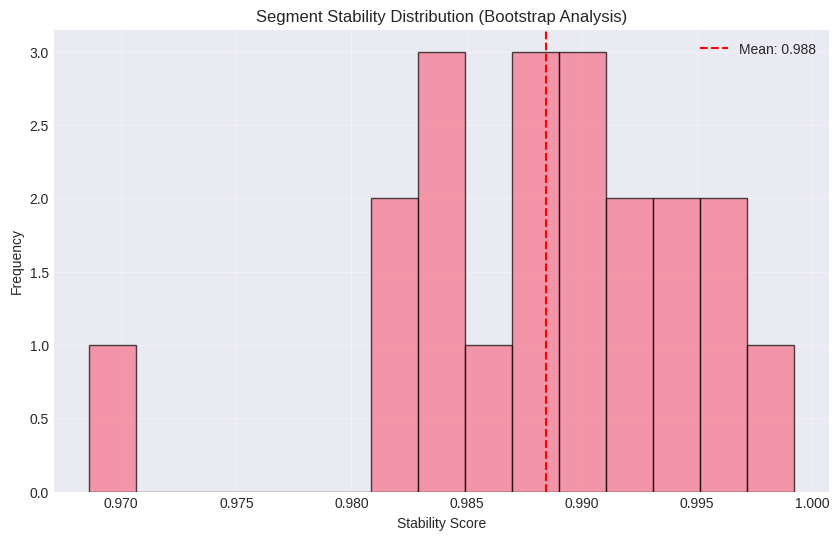

In [53]:

# Visualize stability scores
plt.figure(figsize=(10, 6))
plt.hist(stability_scores, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(stability_scores), color='red', linestyle='--',
            label=f'Mean: {np.mean(stability_scores):.3f}')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.title('Segment Stability Distribution (Bootstrap Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
# %% [markdown]
# ### 7.4 Business Recommendations by Segment

# %%
# Generate business recommendations for each segment
def generate_segment_recommendations(df, segment_profiles):
    """Generate actionable business recommendations for each segment"""

    recommendations = {}

    for cluster in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster]
        segment_name = segment_names.get(cluster, f"Segment {cluster}")

        # Analyze segment characteristics
        avg_balance = cluster_data['avg_balance'].mean()
        avg_products = cluster_data['num_products'].mean()
        avg_risk = cluster_data['risk_score'].mean()
        avg_engagement = cluster_data['engagement_score'].mean()
        digital_usage = cluster_data['digital_usage_rate'].mean()

        # Generate recommendations
        recs = []

        # Product recommendations
        if avg_products < 2:
            recs.append("Cross-sell opportunity: Target for additional products (savings, credit cards)")
        elif avg_products > 4:
            recs.append("Retention focus: High-value multi-product customer - implement loyalty program")

        # Engagement recommendations
        if avg_engagement < 30:
            recs.append("Engagement campaign: Increase digital adoption and transaction frequency")
        elif avg_engagement > 60:
            recs.append("Premium services: Offer exclusive benefits and personalized advisory")

        # Risk recommendations
        if avg_risk > 50:
            recs.append("Risk mitigation: Enhanced monitoring and conservative credit policies")
        elif avg_risk < 20:
            recs.append("Growth opportunity: Pre-approved credit line increases")

        # Digital recommendations
        if digital_usage < 0.5:
            recs.append("Digital transformation: Incentivize mobile app adoption")
        else:
            recs.append("Digital innovation: Beta test new digital features with this segment")

        # Balance recommendations
        if avg_balance < 10000:
            recs.append("Balance building: Savings challenges and automated transfer programs")
        elif avg_balance > 50000:
            recs.append("Wealth management: Introduce investment products and financial planning")

        recommendations[segment_name] = recs

    return recommendations

# Generate recommendations
segment_recommendations = generate_segment_recommendations(df_processed, segment_profiles)

# Display recommendations
print("💡 Business Recommendations by Segment:\n")
for segment, recs in segment_recommendations.items():
    print(f"{segment}:")
    for rec in recs:
        print(f"  • {rec}")
    print()

💡 Business Recommendations by Segment:

Standard Segment 0:
  • Growth opportunity: Pre-approved credit line increases
  • Digital transformation: Incentivize mobile app adoption
  • Balance building: Savings challenges and automated transfer programs

Standard Segment 1:
  • Risk mitigation: Enhanced monitoring and conservative credit policies
  • Digital transformation: Incentivize mobile app adoption
  • Balance building: Savings challenges and automated transfer programs

Standard Segment 2:
  • Growth opportunity: Pre-approved credit line increases
  • Digital transformation: Incentivize mobile app adoption
  • Balance building: Savings challenges and automated transfer programs



In [60]:
# %% [markdown]
# ### 7.5 Export Segment Results

# %%
# Prepare final segmented dataset for export
final_df = df_processed[['customer_id', 'cluster', 'segment_name'] +
                       key_numerical + key_categorical].copy()

# Save to CSV
output_filename = 'customer_segments.csv'
final_df.to_csv(output_filename, index=False)
print(f"✅ Segmentation results saved to '{output_filename}'")

# Create segment summary report
summary_report = {
    'execution_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_customers': len(df_processed),
    'number_of_segments': optimal_clusters,
    'clustering_algorithm': 'K-Means',
    'silhouette_score': final_silhouette,
    'stability_score': np.mean(stability_scores),
    'segments': {}
}

for cluster in sorted(df_processed['cluster'].unique()):
    cluster_data = df_processed[df_processed['cluster'] == cluster]
    summary_report['segments'][int(cluster)] = {
        'name': segment_names.get(cluster),
        'size': int(len(cluster_data)),
        'percentage': round(len(cluster_data) / len(df_processed) * 100, 2),
        'avg_income': round(cluster_data['income'].mean(), 2),
        'avg_balance': round(cluster_data['avg_balance'].mean(), 2),
        'avg_credit_score': round(cluster_data['credit_score'].mean(), 2),
        'avg_products': round(cluster_data['num_products'].mean(), 2)
    }

# Convert numpy types to standard Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(elem) for elem in obj]
    else:
        return obj

summary_report_serializable = convert_numpy_types(summary_report)


# Save summary report
import json
with open('segmentation_summary.json', 'w') as f:
    json.dump(summary_report_serializable, f, indent=4)
print(f"✅ Summary report saved to 'segmentation_summary.json'")

✅ Segmentation results saved to 'customer_segments.csv'
✅ Summary report saved to 'segmentation_summary.json'


In [61]:


# %% [markdown]
# ## 8. Conclusions <a id='conclusions'></a>

# %%
print("🎯 Customer Segmentation Analysis Complete!")
print("="*50)
print(f"\n📊 Summary Statistics:")
print(f"- Total customers analyzed: {len(df_processed):,}")
print(f"- Number of segments identified: {optimal_clusters}")
print(f"- Overall silhouette score: {final_silhouette:.3f}")
print(f"- Segment stability score: {np.mean(stability_scores):.3f}")

print(f"\n📋 Segment Distribution:")
for cluster in sorted(df_processed['cluster'].unique()):
    name = segment_names.get(cluster, f"Segment {cluster}")
    size = len(df_processed[df_processed['cluster'] == cluster])
    pct = size / len(df_processed) * 100
    print(f"- {name}: {size:,} customers ({pct:.1f}%)")

print(f"\n✅ Key Deliverables:")
print(f"1. Segmented customer database: '{output_filename}'")
print(f"2. Segmentation summary report: 'segmentation_summary.json'")
print(f"3. Preprocessing pipeline: Ready for production deployment")
print(f"4. Business recommendations: Generated for each segment")

print(f"\n🚀 Next Steps:")
print("1. Review segment profiles with business stakeholders")
print("2. Implement targeted marketing campaigns for each segment")
print("3. Develop segment-specific product offerings")
print("4. Set up monitoring for segment drift over time")
print("5. Integrate segmentation with loan prediction model")

# %%
# Display final segment profiles for reference
print("\n📊 Final Segment Profiles:")
display_columns = ['cluster', 'size', 'percentage', 'age_mean', 'income_mean',
                  'avg_balance_mean', 'credit_score_mean', 'num_products_mean',
                  'risk_score_mean', 'engagement_score_mean']
print(segment_profiles[display_columns].round(2).to_string(index=False))

🎯 Customer Segmentation Analysis Complete!

📊 Summary Statistics:
- Total customers analyzed: 5,000
- Number of segments identified: 3
- Overall silhouette score: 0.233
- Segment stability score: 0.988

📋 Segment Distribution:
- Standard Segment 0: 827 customers (16.5%)
- Standard Segment 1: 378 customers (7.6%)
- Standard Segment 2: 3,795 customers (75.9%)

✅ Key Deliverables:
1. Segmented customer database: 'customer_segments.csv'
2. Segmentation summary report: 'segmentation_summary.json'
3. Preprocessing pipeline: Ready for production deployment
4. Business recommendations: Generated for each segment

🚀 Next Steps:
1. Review segment profiles with business stakeholders
2. Implement targeted marketing campaigns for each segment
3. Develop segment-specific product offerings
4. Set up monitoring for segment drift over time
5. Integrate segmentation with loan prediction model

📊 Final Segment Profiles:
 cluster  size  percentage  age_mean  income_mean  avg_balance_mean  credit_score_mea